### imports


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from common import read_data

folder = "2198"

In [4]:

def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)


def ecdf(x):
    """convenience function for computing the empirical CDF"""
    vals, counts = np.unique(x, return_counts=True)
    ecdf = np.cumsum(counts).astype(np.float64)
    ecdf /= ecdf[-1]
    return vals, ecdf


In [4]:

def show_cdf_feature(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    plt.plot(cdf_normalized, color='b')
    plt.hist(img.flatten(), 256, [0, 256], color='r')
    plt.xlim([0, 256])
    plt.legend(('cdf', 'histogram'), loc='upper left')
    plt.show()

In [6]:

def plot_ckpt_histogram(ckpt_hist_data):
    """
        [ idx, left_list, right_hist ]
    """
    # show the original histogram
    left_hist, right_hist, avg_hist = [], [], []
    idx = []
    for i, line in enumerate(ckpt_hist_data):
        left_hist.append(line[1])
        right_hist.append(line[2])
        avg_hist.append((line[1] + line[2]) / 2)
        idx.append(i)
    
    plt.plot(np.array(idx), np.array(left_hist), '-', label='left histogram', color='blue')
    plt.plot(np.array(idx), np.array(right_hist), '-', label='right histogram', color='red')
    plt.legend()
    # plt.show()
    plt.savefig("histogram.png")

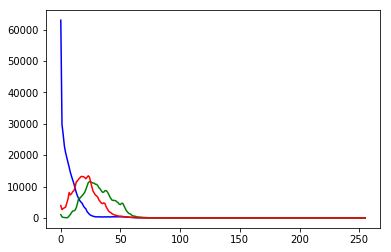

In [7]:
# show the color histograms of left

img = cv2.imread('left_overlap.jpg')
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    histr = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(histr, color=col)
plt.savefig("left_histogram.png")



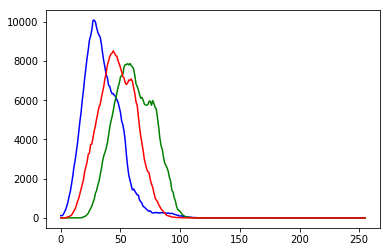

In [8]:

img = cv2.imread('right_overlap.jpg')
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    histr = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(histr, color=col)
plt.savefig("right_histogram.png")


### Before Calibration

In [8]:
# split the blue channel from original image and analysis 

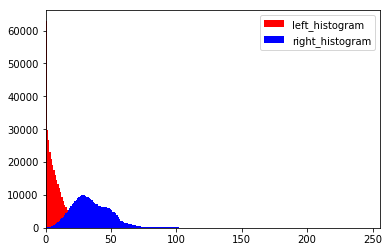

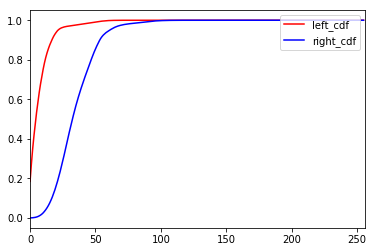

In [10]:


# left histogram and cdf feature
left = cv2.split(cv2.imread('left_overlap.jpg'))[0]
right = cv2.split(cv2.imread('right_overlap.jpg'))[0]


left_hist, left_bins = np.histogram(left.flatten(), 256, [0, 256])
left_cdf = left_hist.cumsum()
left_cdf_normalized = left_cdf / left_cdf.max()

right_hist, right_bins = np.histogram(right.flatten(), 256, [0, 256])
right_cdf = right_hist.cumsum()
right_cdf_normalized = right_cdf / right_cdf.max()

plt.hist(left.flatten(), 256, [0, 256], color='r')
plt.hist(right.flatten(), 256, [0, 256], color='b')
plt.xlim([0, 256])
plt.legend(('left_histogram', 'right_histogram'), loc='upper right')
plt.show()

plt.plot(left_cdf_normalized, color='r')
plt.plot(right_cdf_normalized, color='b')
plt.xlim([0, 256])
plt.legend(('left_cdf', 'right_cdf'), loc='upper right')
plt.show()


### After Calibration

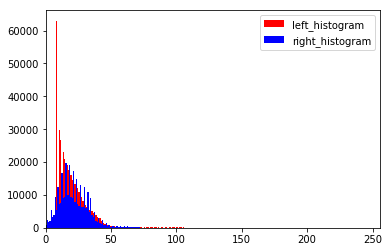

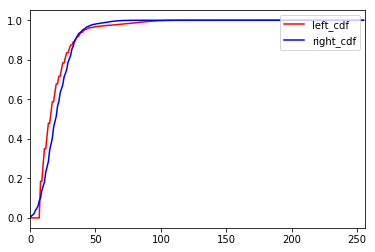

In [47]:
coefs = [1.558824, 8.500000, 0.736111, -4.013889, 2.886800]

# left histogram and cdf feature
calib_left = coefs[0] * left + coefs[1]

# right histogram and cdf feature  
calib_right = coefs[2] * right + coefs[3]

left_hist, left_bins = np.histogram(calib_left.flatten(), 256, [0, 256])
left_cdf = left_hist.cumsum()
left_cdf_normalized = left_cdf / left_cdf.max()

right_hist, right_bins = np.histogram(calib_right.flatten(), 256, [0, 256])
right_cdf = right_hist.cumsum()
right_cdf_normalized = right_cdf / right_cdf.max()

plt.hist(calib_left.flatten(), 256, [0, 256], color='r')
plt.hist(calib_right.flatten(), 256, [0, 256], color='b')
plt.xlim([0, 256])
plt.legend(('left_histogram', 'right_histogram'), loc='upper right')
plt.show()

plt.plot(left_cdf_normalized, color='r')
plt.plot(right_cdf_normalized, color='b')
plt.xlim([0, 256])
plt.legend(('left_cdf', 'right_cdf'), loc='upper right')
plt.show()

In [12]:
coefs = [
    [1.558824, 8.500000, 0.736111, -4.013889, 2.886800],
    [1.171875, 8.578125, 0.872093, -6.383721, 2.886800],
    [1.214286, 8.500000, 0.850000, -5.950000, 2.886800]
]

left = cv2.imread('left_overlap.jpg')
right = cv2.imread('right_overlap.jpg')

left_bgr = cv2.split(left)
right_bgr = cv2.split(right)

calib_left_bgr = []
calib_right_bgr = []
for ch in range(3):
    calib_left_bgr.append(left_bgr[ch] * coefs[ch][0] + coefs[ch][1])
    calib_right_bgr.append(right_bgr[ch] * coefs[ch][2] + coefs[ch][3])


calib_left = cv2.merge(calib_left_bgr)
calib_right = cv2.merge(calib_right_bgr)

cv2.imwrite("calib_left_overlap.jpg", calib_left)
cv2.imwrite("calib_right_overlap.jpg", calib_right)

True